# 521153S, Deep Learning Final Project: Mini Image classification Competition with CNN

## Outline 
### In this assignment, you will learn:
* Combine all you learned from the previous assignments.
* Build your own CNN as you like with Pytorch, train and validate it on a given dataset.
* Test your CNN model on our server.

### Tasks (<span style="color:orange">40 points</span>)
We want to keep the task as clean and simple as possible. 
1. You would be given a dataset containing 45,000 grayscale 32x32 images. Also, we will set a private testing data and upload it to our server. You could only use the private testing data to test your model. Instructions about evaluating your model would be given along with the project in Moodle.
2. Before evaluating your model on the server, you have to train your model based on the given 45,000 images. Specifically, in these images, there are nine classes, and each class has 5000 images. The testing data on the server has 9000 images, and each class has 1000 images.
3. To get a good CNN model, basically, there are some rules for you to follow which would be considered when grading your report:
  * Make the best out of the given images. It means you have to split it into training and validation set, training your model on the training set and validating the trained model on the validation set. If the accuracy on the validation set is not good, then you have to adjust your CNN model structure or some adjustable parameters. For example, batch size, learning rate, momentum on SGD, lambda in weight decay, etc.  Then retrain your model until the accuracy on the validation set is good enough because the testing data would have similar accuracy with the validation set. 
  * It also means that you could do some augmentation on the training set. This includes randomly flipping, cropping a small window in a random location within the image(refer to assignment 4), adding some noise, resizing-and-cropping, etc. All these are to make the training process more tolerant. 
  * From the CNN structure perspective, you also need to design your CNN model by yourself. Well-known network architecture you can use includes [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/abs/1512.00567), [VGGNet](https://arxiv.org/abs/1409.1556), [DenseNet](https://arxiv.org/abs/1608.06993), [MobileNet](https://arxiv.org/abs/1801.04381), [ShuffleNet](https://arxiv.org/abs/1807.11164), [ResNeXt](https://arxiv.org/abs/1611.05431) etc. 
4. Similar to real-life applications, your model will be tested with unknown data. In this project,  after training and validating the model, you need to test it on our hold-on testing dataset. We will provide you with a submission server and a leaderboard. The instructions would be given alongside the project in Moodle. 
5. Please give a pdf report (also your source code, e.g., this Jupyter notebook file), documenting the whole model training process and also the evaluated accuracy on the server. Tensorboard visualization is also necessary for your report to visualize your network structure, accuracy, and losses, etc. as done in assignment 4.
6. You need to return the pdf report as well as your trained model (a checkpoint file) with your source code file to moodle. We will run your model on the server and compare the results with the one written in the reports. 

### Grading
You can get 40 points in total.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your model achieve more than 82.5% of the testing accuracy.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your report is clear and well-organized.
  
### Files you have to submit
please submit a .zip file containing:
1. a pdf report;
2. source code files (jupyter notebook or common python files);
3. a checkpoint file (which saves your trained model).

### Group members
Maximum 2 members. 


### Environment
Python 3, Numpy, matplotlib, torch, torchvision...

### Dataset
Please follow the code below to download the 45,000 images and corresponding labels. <br>
We have already split them into training and validation set; please refer to assignment 3 and 4 to create your DataLoader, with your data augmentation methods. Good luck. 

#### Download the given dataset

In [2]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torchvision.models.resnet import BasicBlock
from torch.utils.tensorboard import SummaryWriter

download_given_data('./')

Data was already downloaded and extracted!


**Create a dataset class for our Mini ImageNet dataset**

In [3]:
class MiniImageNetDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

### Dataset checking ###

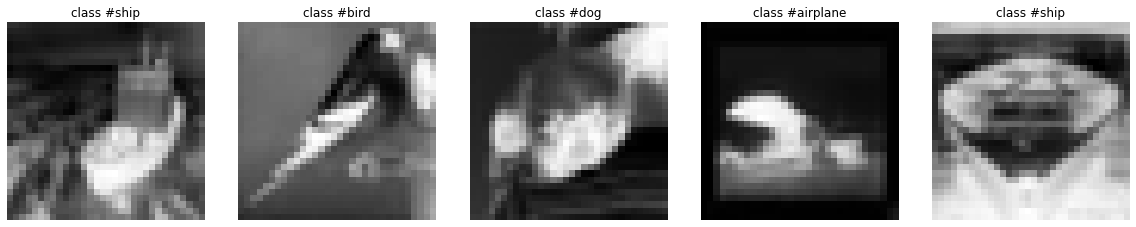

total number of training set: 36000
numer of images for class airplane: 4000
numer of images for class automobile: 4000
numer of images for class bird: 4000
numer of images for class cat: 4000
numer of images for class deer: 4000
numer of images for class dog: 4000
numer of images for class frog: 4000
numer of images for class horse: 4000
numer of images for class ship: 4000


In [6]:
train_set = MiniImageNetDataset(csv_file='./given_data/train.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(10, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

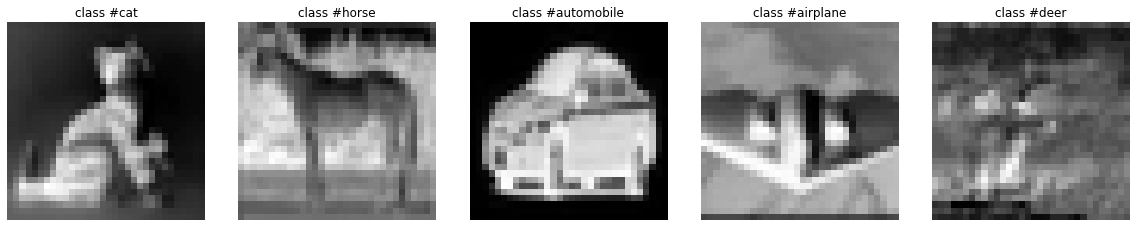

total number of validing set: 9000
numer of images for class airplane: 1000
numer of images for class automobile: 1000
numer of images for class bird: 1000
numer of images for class cat: 1000
numer of images for class deer: 1000
numer of images for class dog: 1000
numer of images for class frog: 1000
numer of images for class horse: 1000
numer of images for class ship: 1000


In [11]:
valid_set =  MiniImageNetDataset(csv_file='./given_data/val.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = valid_set.label_names[label]    

    # TODO: show plots
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# TODO: Print the number of total images in the validation set    
print('total number of validing set: {}'.format(len(valid_set)))

# TODO: Print the number of images per class in the validation set
class_num_val = np.zeros(10, dtype=np.int32)
for x in valid_set:
    class_num_val[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(valid_set.label_names[i], class_num_val[i]))

### Build our custom data augmentation

We can define a custom data transformation for data augmentation namely RandomWindowDrop. There are 50%/50% chance that it will randomly cut a square window inside our image or horizontally flip the image.

In [15]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define a horizontalFlip
        self.trans = transforms.RandomHorizontalFlip(p=1.0)

    def __call__(self, sample):
        image = sample

        # Perform either RandomWindowDrop or RandomHorizontalFlip
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        else:
            image = self.trans(image)

        return image

**Load the training/validation data to Dataloader**

In [17]:
def getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    # transforms.Compose create a list of transformations
    transformed_training = MiniImageNetDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training


def getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_eval = MiniImageNetDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_eval

In [19]:
train_loader = getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0)

# TODO: create valid_loader with no shuffling (0.5 points)
# batch_size = 64
valid_loader = getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0)

###  Define the Network Architecture in Pytorch ###

In [34]:
## ------ ResNet18 -------- ##
class ResNet18_Fashion_MNIST(torchvision.models.ResNet):
    def __init__(self, num_classes=9):
        super(ResNet18_Fashion_MNIST, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        # Override the "conv1" layer from the resnet-18 model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
    def forward(self, x):
        return super(ResNet18_Fashion_MNIST, self).forward(x)

In [ ]:
### Define ResNet and modify some layers
## ------ ResNet50 -------- ##

resnet50 = models.resnet50(pretrained=False)
### Modify the number of neurons in output layer ---- set 9 classes
resnet.fc = nn.Linear(2048, 9) 
resnet.conv1 = nn.Conv2d(3, 64,kernel_size=5, stride=2, padding=3, bias=False)

### Set Parameteres ###

In [39]:
#Initialize the network and optimizer
model = ResNet18_Fashion_MNIST(num_classes= 9).float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#####Change model to cuda
if torch.cuda.is_available():
    model = model.cuda()

# Declare the optimizer for the network
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [37]:
# evaluation function
def eval(net, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        outs = net(images) 
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)
        
    correct = correct.type(torch.DoubleTensor)
    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    start_t = time.time()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay (0.5 points)
    ### Set Weight dacay as e-4
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay= 1e-4)
    
    #fill the blank bracket
    ### Increase epoches as 20
    epoches = 2
    for epoch in range(epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
#         ### set learning rate decay
#         if epoch % 4 is 1:
#             learning_rate = learning_rate * 0.8
#             optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay= 1e-10) 
        for i, sample in enumerate(train_loader):
            images, labels = sample['image'], sample['label']
            images, labels = images.to(device),labels.to(device)
            # TODO: fill these blanks (0.5 points)
            outs = net(images)
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            
            # TODO: clear grads (0.5 points)          
            optimizer.zero_grad()
            
            # TODO: backward propogation (0.5 points)
            loss = loss_function(outs, labels)
            loss.backward()

            # TODO: update parameters (0.5 points)
            optimizer.step()
            net.eval()

        correct = correct.type(torch.DoubleTensor)
        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))
        print('Elapsed time: {:.02f} seconds'.format(time.time()-start_t))
    return net

In [41]:
if torch.cuda.is_available():
    net = net.cuda()
    
train(model, train_loader, valid_loader)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 51380224 bytes. Buy new RAM!
